This demonstrates all the steps in my candidate selection before conducting visual inspection

In [1]:
import numpy as np
import splat
import wisps.data_analysis as wispd
from wisps.data_analysis import selection_criteria as sel_crt
import shapey
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wisps

import matplotlib as mpl

from tqdm import tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#some functions 
def get_indices(x):
    if x is None :
        return pd.Series({})
    else:
        return  pd.concat([pd.Series(x.indices), pd.Series(x.mags), pd.Series(x.snr)])
    
def get_spt(x):
    if x is None:
        return np.nan
    else:
        return x.spectral_type[0]

def box_parameters(idx, spt_range):
    bs=idx.shapes
    b=[x for x in bs if x.shape_name==spt_range][0]
    print ('{}  {} m: {} b: {} s:{}, comp : {}, cont: {}'.format(spt_range, idx,  round(b.coeffs[0], 2), round(b.coeffs[1], 2), round(b.scatter, 2), round(idx.completeness[spt_range], 2),  round(idx.contamination[spt_range], 3)))

In [3]:
#get data
alldata=pd.read_hdf(wisps.LIBRARIES+'/master_dataset.hdf',  key='new')
star_ids=alldata[alldata['class_star'] !=0]
stars=wisps.Annotator.reformat_table(star_ids).reset_index(drop=True)
spex=wisps.Annotator.reformat_table(wisps.datasets['spex'])
#cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf')
cands0=pd.read_hdf(wisps.LIBRARIES+'/objects_of_interest.hdf', key='all')
cands0=(cands0[~cands0.spectra.isna()]).reset_index(drop=True)
cands=cands0.spectra.apply(get_indices)
cands['grism_id']=cands0.grism_id
cands['spt']=cands0.spectra.apply(get_spt)
cands=wisps.Annotator.reformat_table(cands)
cands=cands[(cands.spt >=17.) ]
cands_dff=cands.reset_index(drop=True)

dt=stars[(stars.f_test< 0.4) &(stars.snr1>=3.)].reset_index(drop=True)
dt['spt']=(dt['spt']).apply(wisps.make_spt_number).apply(float)

spex_df=wisps.Annotator.reformat_table(wisps.datasets['spex']).reset_index(drop=True)
manj=wisps.Annotator.reformat_table(wisps.datasets['manjavacas']).reset_index(drop=True)
schn=wisps.Annotator.reformat_table(wisps.datasets['schneider']).reset_index(drop=True)
ydwarfs=(manj[manj['spt'].apply(wisps.make_spt_number)>38].append(schn)).reset_index(drop=True)
spex_df['spt']=np.vstack(spex_df['spt'].values)[:,0]
manj['spt']=np.vstack(manj['spt'].values)[:,0]
schn['spt']=np.vstack(schn['spt'].values)[:,0]

cands_dff.grism_id=cands_dff.grism_id.apply(lambda x: x.lower())
stars.grism_id=stars.grism_id.apply(lambda x: x.lower())

cx=cands_dff[cands_dff.grism_id.isin(stars.grism_id)]
cy=stars[stars.grism_id.isin(cx.grism_id)]
cands_dff['spt']=np.vstack(cands_dff['spt'].values)
cands_dff=wisps.Annotator.reformat_table(cands_dff)

In [4]:
#get criteria 
##only run this if new data
#gbhio=sel_crt.save_criteria(conts=dt)
crts=sel_crt.crts_from_file()
contamns=pd.DataFrame([ x.contamination for x in crts.values()])
compls=pd.DataFrame([ x.completeness for x in crts.values()])

contamns.index=[x for x in crts.keys()]
compls.index=[x for x in crts.keys()]

In [5]:
len(alldata), len(stars), len(dt), len(stars[stars.snr1>3.])

(254264, 104346, 28443, 45344)

In [6]:
%%capture
'''
contamns.style.apply(lambda x: ["background-color: #7FDBFF" 
                          if (i >= 0 and (v < 0.1 
                                          and v > 0. )) 
                          else "" for i, v in enumerate(x)], axis = 1)
'''

In [7]:
contamns.idxmin(axis=0)# the least contaminated criteria
#add new criteria to avoid repet

L0-L5               H-cont/H_2O-2 CH_4/H-Cont
L5-T0          CH_4/H_2O-2 H_2O-2+CH_4/J-Cont
M7-L0        CH_4/H-Cont H_2O-1+H_2O-2/J-Cont
T0-T5        CH_4/H_2O-2 H_2O-1+H_2O-2/J-Cont
T5-T9        H-cont/H_2O-1 H_2O-1+CH_4/H-Cont
subdwarfs         H_2O-1/J-Cont H-cont/J-Cont
trash               H_2O-1/J-Cont CH_4/H-Cont
Y dwarfs     H_2O-1/J-Cont H_2O-1+CH_4/H-Cont
dtype: object

In [8]:
#copy paste the best indices here manually
to_use={'H_2O-1/J-Cont CH_4/H-Cont':'L0-L5',
        'CH_4/H_2O-2 H_2O-2+CH_4/J-Cont':'L5-T0' ,
        'CH_4/H-Cont H_2O-1+H_2O-2/J-Cont':'M7-L0',
        'CH_4/H_2O-2 H_2O-1+H_2O-2/J-Cont': 'T0-T5',
        'H-cont/H_2O-1 H_2O-1+CH_4/H-Cont': 'T5-T9',
        'H_2O-1/J-Cont H_2O-1+CH_4/H-Cont': 'Y dwarfs',
        'H_2O-1/J-Cont H-cont/J-Cont': 'subdwarfs'}

In [9]:
#check for repeated keywords
len(to_use)

7

In [10]:
import pickle
#save the random forest
output_file=wisps.OUTPUT_FILES+'/best_indices_to_use.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(to_use,file)

In [11]:
fp={}

In [12]:
def plot_index_box(index_name, box_name, ax):
    
    #get the index and the box
    idx=crts[index_name]
    bx=[x for x in idx.shapes if x.shape_name==box_name][0]
    
    xkey=idx.xkey
    ykey=idx.ykey

    to_use_df=spex_df
    if box_name.lower()=='y dwarfs':
        to_use_df=ydwarfs
    if box_name.lower()=='subdwarfs':
        to_use_df=wisps.Annotator.reformat_table(idx.subdwarfs)
        to_use_df['spt']=17
    
    
    #remove nans from background
    bckgrd= dt[[xkey, ykey]].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna()

    h=ax.scatter(bckgrd[xkey].apply(float).values, bckgrd[ykey].apply(float).values, s=1., c='#111111', alpha=0.1)
    
    cands_slctd, cands_bools=bx._select(np.array([cands_dff[xkey].values,cands_dff[ykey].values]))
   
    trash_slctd, trsh_bools=bx._select(np.array([dt[xkey].values, dt[ykey].values]))
    
    #simul_slctd, simul_bools=bx._select(np.array([simulated_data[xkey].values, simulated_data[ykey].values]))
    
    
    cands_in_that_class_bool=(cands_dff[ cands_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    spexs_slctd_in_that_class_bool= (to_use_df).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    #simulated_in_that_class_bool=(simulated_data[simul_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    if box_name.lower()=='subdwarfs':
         spexs_slctd_in_that_class_bool=np.ones(len(to_use_df), dtype=bool)
    
    
    
    
    cands_in_that_class=np.array([cands_slctd[0][cands_in_that_class_bool], cands_slctd[1][cands_in_that_class_bool]])
    
    #simulated_in_that_class= np.array([simul_slctd[0][simulated_in_that_class_bool], simul_slctd[1][simulated_in_that_class_bool]])
    
    spexs_slctd_in_that_class=np.array([to_use_df[xkey][spexs_slctd_in_that_class_bool], to_use_df[ykey][spexs_slctd_in_that_class_bool]])
    

    #ax.scatter( simulated_in_that_class[0],    simulated_in_that_class[1], facecolors='none', s=10, 
    #           edgecolors='#001f3f', label='simulated')
    
    ax.scatter(spexs_slctd_in_that_class[0], spexs_slctd_in_that_class[1], facecolors='#0074D9',  label='SpeX', s=30.)
    
    ax.scatter(cands_dff[xkey], cands_dff[ykey], marker='x', facecolors='#111111', s=30.)
    
    
    ax.scatter( cands_in_that_class[0],    cands_in_that_class[1], marker='x', facecolors='#FF4136', s=30, 
               edgecolors='#FF4136', label='candidates')
    
    
    
    
    bx.color='None'
    bx.alpha=1.
    bx.linewidth=3
    bx.linestyle='-'
    bx.edgecolor='#0074D9'
    bx.plot(ax=ax, only_shape=True, highlight=False)
    
    
    ax.set_xlabel(r'$'+str(idx.name.split(' ')[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(idx.name.split(' ')[1])+'$', fontsize=15)
    
    ax.set_title(box_name, fontsize=18)
    
    xbuffer=np.nanstd(to_use_df[[xkey,ykey]])
    
    ax.set_xlim([ bx.xrange[0]-0.5*abs(np.ptp(bx.xrange)), bx.xrange[1]+0.5*abs(np.ptp(bx.xrange))])
    ax.set_ylim([ bx.yrange[0]-0.5*abs(np.ptp(bx.yrange)), bx.yrange[1]+0.5*abs(np.ptp(bx.yrange))])
    
    ax.minorticks_on()
    

    if (trash_slctd.shape[1])==0:
        fprate=0.0
    else:
        fprate=(trash_slctd.shape[1]- cands_slctd.shape[1])/trash_slctd.shape[1]
        if box_name.lower()=='subdwarfs':
                fprate=1.
    
    fp[box_name]=  fprate
    
    plt.tight_layout()
    print (' {} selected {}'.format(box_name, len(bx.select( bckgrd))))
    
    return {str(box_name): bx}
    
    

 L0-L5 selected 2256
 L5-T0 selected 585
 M7-L0 selected 3191
 T0-T5 selected 49
 T5-T9 selected 2
 Y dwarfs selected 1
 subdwarfs selected 6431


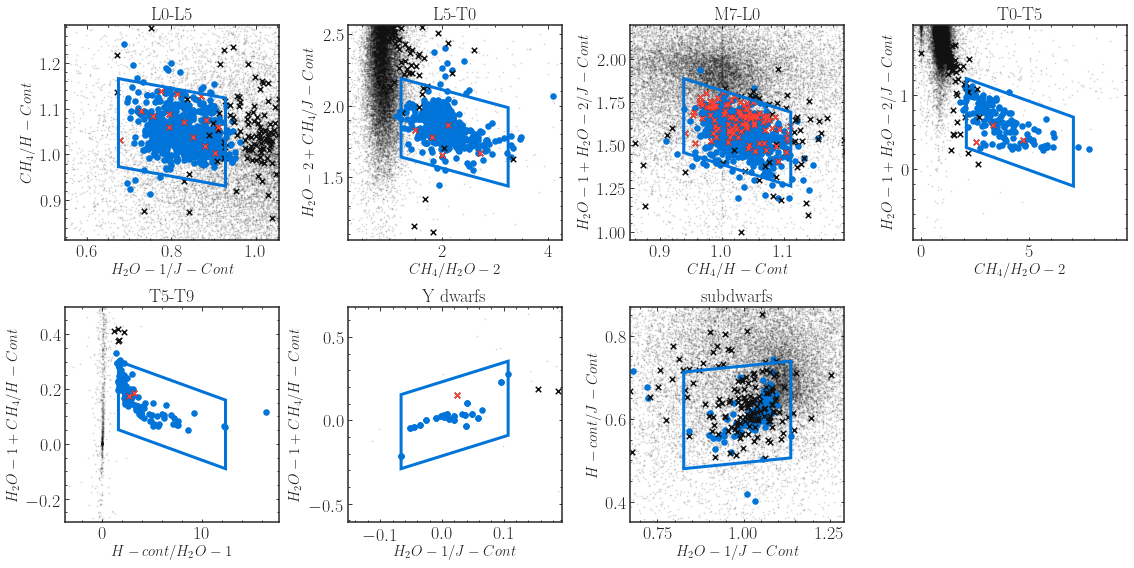

In [13]:
fig, ax=plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

bxs=[]
for idx, k in enumerate(to_use.keys()):
    b=plot_index_box( k, to_use[k], np.concatenate(ax)[idx])
    bxs.append(b)



plt.tight_layout()


fig.delaxes(np.concatenate(ax)[-1])
#subdindx_index_crt=crts['H_2O-1/J-Cont H_2O-2/H_2O-1']
#subdrfs=wisps.Annotator.reformat_table(dummy_index_crt.subdwarfs)
#tpls=wisps.Annotator.reformat_table(spex_df[spex_df.metallicity_class.isna()])
#a=np.concatenate(ax)[-1]
#tpls=tpls[tpls.spt>16]

#a.scatter(dt[subdindx_index_crt.xkey], dt[subdindx_index_crt.ykey], s=1., c='#111111', alpha=0.1)
#a.scatter(tpls[subdindx_index_crt.xkey], tpls[subdindx_index_crt.ykey], marker='+', facecolors='#0074D9',  label='SpeX', s=5.)
#a.scatter(subdrfs[subdindx_index_crt.xkey], subdrfs[subdindx_index_crt.ykey], marker='+', facecolors='#2ECC40',  label='SpeX', s=30.)


#a.set_xlim([0., 1.35])
#a.set_ylim([0., 1.25])
#a.set_title('subdwarfs', fontsize=18)
#a.set_xlabel(r'$'+str(subdindx_index_crt.name.split(' ')[0])+'$', fontsize=15)
#a.set_ylabel(r'$'+str(subdindx_index_crt.name.split(' ')[1])+'$', fontsize=15)
    

plt.savefig(wisps.OUTPUT_FIGURES+'/index_index_plots.pdf', bbox_inches='tight', rasterized=True)

In [14]:
common=dt[dt.grism_id.isin(cands.grism_id)]

In [15]:
#.grism_id.to_csv('/users/caganze/desktop/true_brown_dwarfs.csv')

In [16]:
bx_dict={}
for b in bxs:
    bx_dict.update(b)

In [17]:
#invert to use
inv_to_use = {v: k for k, v in to_use.items()}

In [18]:
ncandidates=[]
for spt_range in bx_dict.keys():
    idx_name=inv_to_use[spt_range]
    idx=crts[idx_name]
    s, bools=(bx_dict[spt_range])._select(np.array([dt[idx.xkey].values, dt[idx.ykey].values]))
    ncandidates.append(dt[bools])

In [19]:
candsss=(pd.concat(ncandidates).drop_duplicates(subset='grism_id'))
cands_dff.grism_id=cands_dff.grism_id.apply(lambda x: x.lower())
good_indices=[crts[x] for x in inv_to_use.values()]

In [20]:
len(candsss), len(candsss[candsss.grism_id.isin(cands_dff.grism_id) & (candsss.spt.apply(wisps.make_spt_number)>16)])

(9465, 155)

In [21]:
len(candsss.drop_duplicates('grism_id'))/len(alldata)

0.03722508888399459

In [22]:
len(candsss[candsss.grism_id.isin(cands_dff.grism_id) & (candsss.spt.apply(wisps.make_spt_number)>=17)])

155

In [23]:
candsss.to_pickle(wisps.OUTPUT_FILES+'/selected_by_indices.pkl')

In [24]:
#print out table
def round_tuple(tpl, n=2):
    return round(tpl[0], n), round(tpl[1],n)

for sindex, k in zip(good_indices, to_use.keys()):
   
    spt_range=to_use[k]
    bs=sindex.shapes
    bs=[x for x in bs if x.shape_name==spt_range]

    bx=bs[0]
    
    print (" {} & {} &  {} & {} & {} & {} & {} & {} & {}  & {} \\\ ".format(spt_range,sindex.xkey, sindex.ykey, 
                                                                           round_tuple(bx.vertices[0]), round_tuple(bx.vertices[1])
                                                                          , round_tuple(bx.vertices[2]), round_tuple(bx.vertices[3]),
                                                                          round(sindex.completeness[spt_range], 2), 
                                                                            round(sindex.contamination[spt_range], 3), 
                                                                           round(fp[spt_range], 2)))
    

 L0-L5 & H_2O-1/J-Cont &  CH_4/H-Cont & (0.67, 1.17) & (0.93, 1.12) & (0.93, 0.93) & (0.67, 0.97) & 0.97 & 0.079  & 0.99 \\ 
 L5-T0 & CH_4/H_2O-2 &  H_2O-2+CH_4/J-Cont & (1.23, 2.19) & (3.24, 1.99) & (3.24, 1.44) & (1.23, 1.64) & 0.95 & 0.021  & 0.98 \\ 
 M7-L0 & CH_4/H-Cont &  H_2O-1+H_2O-2/J-Cont & (0.94, 1.89) & (1.11, 1.69) & (1.11, 1.26) & (0.94, 1.46) & 0.97 & 0.112  & 0.97 \\ 
 T0-T5 & CH_4/H_2O-2 &  H_2O-1+H_2O-2/J-Cont & (2.1, 1.22) & (7.05, 0.7) & (7.05, -0.23) & (2.1, 0.29) & 0.97 & 0.002  & 0.84 \\ 
 T5-T9 & H-cont/H_2O-1 &  H_2O-1+CH_4/H-Cont & (1.62, 0.3) & (12.35, 0.16) & (12.35, -0.09) & (1.62, 0.05) & 0.96 & 0.0  & 0.0 \\ 
 Y dwarfs & H_2O-1/J-Cont &  H_2O-1+CH_4/H-Cont & (-0.07, 0.15) & (0.11, 0.35) & (0.11, -0.09) & (-0.07, -0.29) & 0.91 & 0.0  & 0.0 \\ 
 subdwarfs & H_2O-1/J-Cont &  H-cont/J-Cont & (0.83, 0.71) & (1.14, 0.74) & (1.14, 0.51) & (0.83, 0.48) & 0.94 & 0.227  & 1.0 \\ 
